# Initialization

In [1]:
import os
import grasp
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.io import fits
from matplotlib import pyplot as plt
dr3 = grasp.dr3()
gc = grasp.Cluster('ngc6121')

try:
    device_name = os.getenv('COMPUTERNAME')
    if device_name == 'DESKTOP-Work':
        tn1 = '20250402_204446'
        tn2 = '20250402_204448'
        acs = grasp.load_data(tn1)
        pcs = grasp.load_data(tn2)
    elif device_name == 'LAPTOP-Work':
        tn1 = '20250401_164228'
        tn2 = '20250401_164231'
        pcs = grasp.load_data(tn1)
        acs = grasp.load_data(tn2)
    else:
        raise EnvironmentError("Unknown device name")
except Exception:
    astrometry_query = "SELECT source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, \
                        radial_velocity, radial_velocity_error, bp_rp, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.897,-26.526,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND abs(parallax_error/parallax)<0.50\
                        AND abs(pmra_error/pmra)<0.30 \
                        AND abs(pmdec_error/pmdec)<0.30 \
                        AND pmra IS NOT NULL AND abs(pmra)>0 \
                        AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.214805 AND -17.807517"
    
    photometry_query = "SELECT source_id, ra, ra_error, dec_error, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, radial_velocity, radial_velocity_error, \
                        bp_rp, phot_g_mean_mag, phot_bp_rp_excess_factor, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND ruwe < 1.15 \
                        AND phot_g_mean_mag > 11 \
                        AND astrometric_excess_noise_sig < 2 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.2148 AND -17.807517"
    
    acs = dr3.free_query(astrometry_query, save=True)
    acs = grasp.Sample(acs, gc)
    pcs = dr3.free_query(photometry_query, save=True)
    pcs = grasp.Sample(pcs, gc)
    print("\nWARNING! Remember to updates tn after running the new query!!!")


GAIA - GLOBULAR CLUSTERS ANALYSIS SOFTWARE
            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
         ::::::::::;;;::...

             INITIALIZED


Initialized with Gaia table: 'gaiadr3.gaia_source'
Not a Cluster: no model available
Not a Cluster: no model available


# Data visualization

<QTable length=1014>
          name            dtype     class     n_bad
------------------------ ------- ------------ -----
               SOURCE_ID   int64       Column     0
                      ra float64       Column     0
                ra_error float64       Column     0
                     dec float64       Column     0
               dec_error float64       Column     0
                parallax float64       Column     0
          parallax_error float64       Column     0
                    pmra float64       Column     0
              pmra_error float64       Column     0
                   pmdec float64       Column     0
             pmdec_error float64       Column     0
         radial_velocity float64 MaskedColumn   923
   radial_velocity_error float64 MaskedColumn   923
                   bp_rp float64 MaskedColumn    31
         phot_g_mean_mag float64 MaskedColumn     1
        phot_bp_mean_mag float64 MaskedColumn   118
        phot_rp_mean_mag float64 MaskedColu

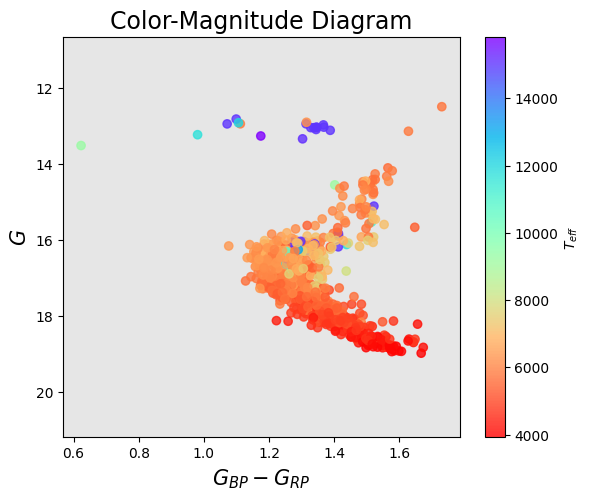

In [2]:
aps = acs.join(pcs)
aps.info()
grasp.plots.colorMagnitude(aps)

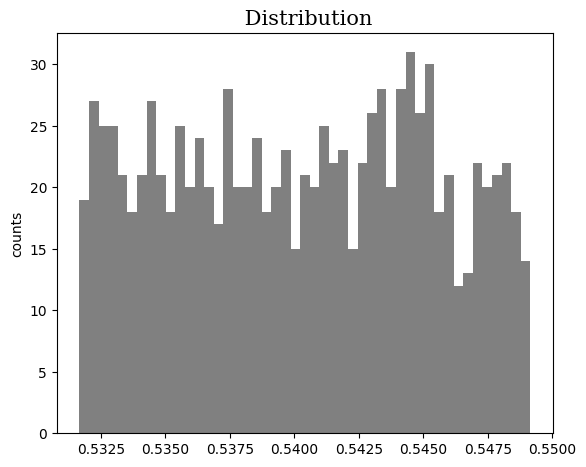

In [3]:
grasp.plots.histogram(aps.parallax)

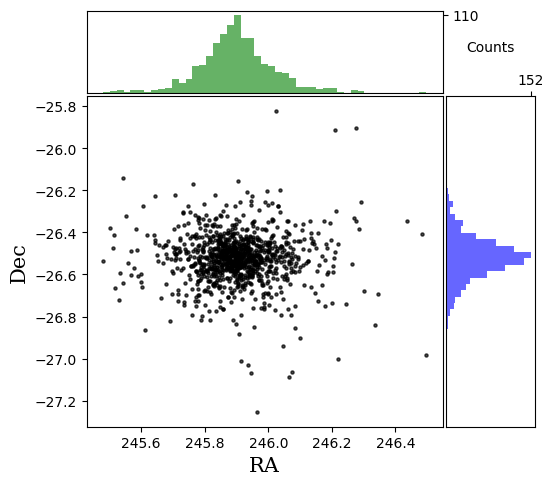

In [4]:
grasp.plots.doubleHistScatter(aps.ra, aps.dec, xlabel='RA', ylabel='Dec')

# Angular Separation Analysis

The `Great Circle` formula versus the `Vincenty Formula` for the computation of distances on a sphere

## $\theta_V$   vs   $\theta_{GC}$

In [5]:
f = grasp.load_base_formulary()
f.substitute('Angular separation', {'alpha_{0}': aps.gc.ra.value, 'delta_{0}':aps.gc.dec.value})

from sympy import atan2
atan_arg_1 = 'sqrt((cos(delta_1*sin((alpha_0 - alpha_1)/2)))**2 + (cos(delta_0)*sin(delta_1) - sin(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2 ))**2)'
atan_arg_2 = '(sin(delta_0)*sin(delta_1) + cos(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2))'
atan = atan2(atan_arg_1, atan_arg_2)
f.add_formula('Vincenty angsep', atan)
f.substitute('Vincenty angsep', {'alpha_0': aps.gc.ra.value, 'delta_0':aps.gc.dec.value})


f.angular_separation

Eq(theta, 2*asin(sqrt(0.178607634074684*sin(alpha_{1}/2 - 122.952679154121)**2*cos(delta_{1}) + sin(delta_{1}/2 + 13.2619832035359)**2)))

In [6]:
f['Vincenty angsep']

Eq(f_0, atan2(sqrt(0.968099313050244*(0.181526511503745*sin(delta_1) + cos(delta_1)*cos(alpha_1/2 - 122.952679154121))**2 + cos(delta_1*sin(alpha_1/2 - 122.952679154121))**2), -0.983920379426224*sin(delta_1) + 0.178607634074684*cos(delta_1)*cos(alpha_1/2 - 122.952679154121)))

In [7]:
f.var_order('Angular Separation')
print('')
f.var_order('Vincenty angsep')


`Angular separation' variables must be passed in the following order:
Data         : [alpha_{1}, delta_{1}]
Errors       : [epsilon_alpha_{1}, epsilon_delta_{1}]
Correlations : [rho_alpha_{1}_delta_{1}]


`Vincenty angsep' variables must be passed in the following order:
Data         : [alpha_1, delta_1]
Errors       : [epsilon_alpha_1, epsilon_delta_1]
Correlations : [rho_alpha_1_delta_1]


Great Circle Distance computation

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Computation using all 16 cores.

Vincenty Distance computation

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_1, delta_1]
Computation using all 16 cores.


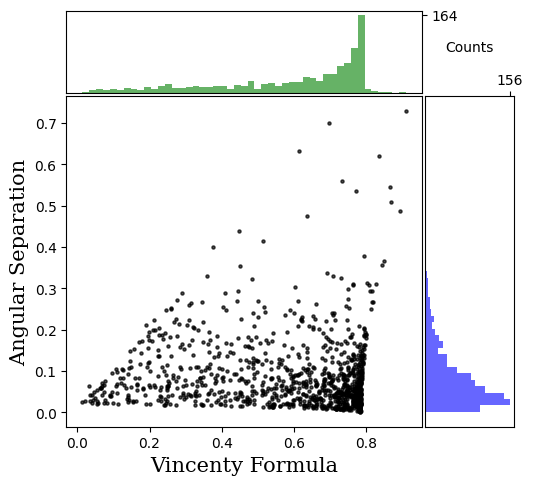

In [8]:
ra, dec = (aps.ra.value, aps.dec.value)
print("Great Circle Distance computation\n")
theta_1 = f.compute('Angular Separation', data={'alpha_{1}': ra, 'delta_{1}': dec}, asarray=True)
print("\nVincenty Distance computation\n")
theta_2 = f.compute('Vincenty angsep', data={'alpha_1': ra, 'delta_1': dec}, asarray=True)

grasp.plots.doubleHistScatter(theta_2, theta_1, xlabel='Vincenty Formula', ylabel='Angular Separation')

Correctly imported `minpack.lm`.


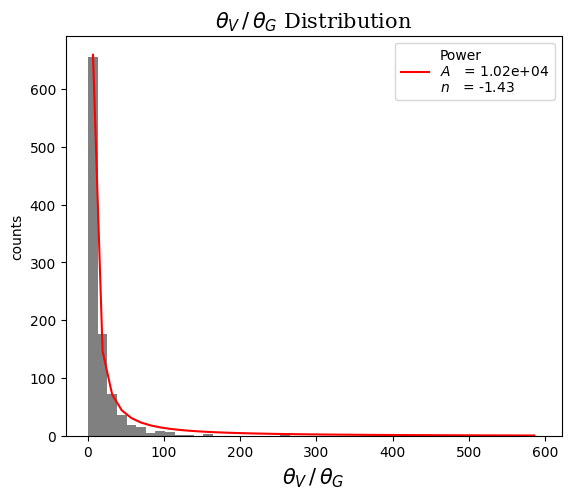

A = 10194.31  ;  lambda = -1.43


In [9]:
t_ratio = theta_2/theta_1
out = grasp.plots.histogram(t_ratio, kde=True, kde_kind='power', xlabel=r'$\theta_V\,/\,\theta_G$', out=True)
fit = out['kde']
print(f"A = {fit[0]:.2f}  ;  lambda = {fit[1]:.2f}")

Exponential fit: A = 0.38  ;  lambda = -1.13


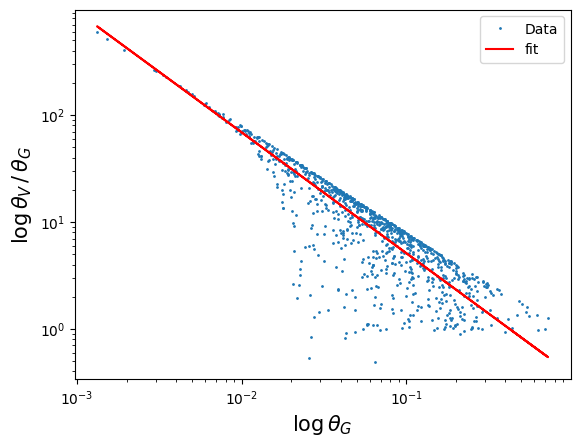

In [10]:
fit = grasp.stats.fit_data(t_ratio[t_ratio<400], fit='power', x_data=theta_1[t_ratio<400])

coeffs = fit.coeffs

exp = grasp.stats._get_function('power')
exp = exp(theta_1, *coeffs)
print(f"Exponential fit: A = {coeffs[0]:.2f}  ;  lambda = {coeffs[1]:.2f}")

plt.plot(theta_1, t_ratio, 'o', markersize=1, label='Data')
plt.plot(theta_1, exp, c='r', label='fit')
plt.xlabel(r'$\log{\theta_G}$', fontdict=grasp.plots.label_font)
plt.ylabel(r'$\log{\theta_V\,/\,\theta_G}$', fontdict=grasp.plots.label_font)
plt.yscale('log')
plt.xscale('log')
plt.legend()

## $r_{2D}(\theta_V)$ vs $r_{2D}(\theta_{GC})$

In [11]:
aps.gc.dist = 1851 # Baumgardt, Vasiliev: 2021 # pc
f.substitute('radial_distance_2d', {'r_{c}': aps.gc.dist})
f.radial_distance_2d

Eq(r_{2}, 1851*tan(theta))

In [12]:
f.var_order('radial_distance_2d')


`Radial distance 2d' variables must be passed in the following order:
Data         : [theta]
Errors       : [epsilon_theta]
Correlations : None


In [13]:
print(r'Computation using $\theta_{GC}$')
r2d_1 = f.compute('radial_distance_2d', data={'theta': theta_1}, asarray=True) # Great Circle
print('')
print(r'Computation using $\theta_{V}$')
r2d_2 = f.compute('radial_distance_2d', data={'theta': theta_2}, asarray=True) # Vincenty Formula

r_ratio = r2d_2/r2d_1

Computation using $\theta_{GC}$
WARNING! Be sure that the input data follow this specific order: 
Data:         [theta]
Computation using all 16 cores.

Computation using $\theta_{V}$
WARNING! Be sure that the input data follow this specific order: 
Data:         [theta]
Computation using all 16 cores.


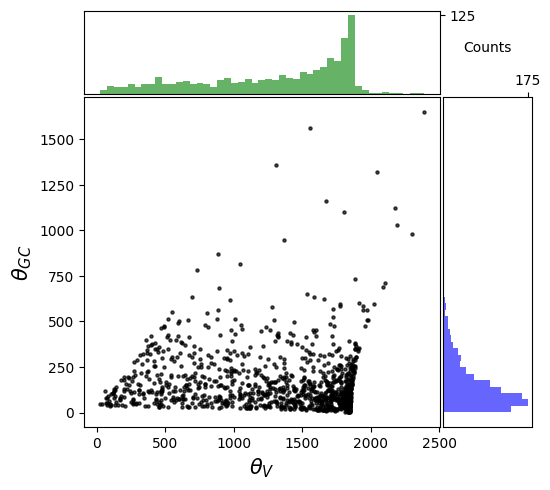

In [14]:
grasp.plots.doubleHistScatter(r2d_2, r2d_1, xlabel=r'$\theta_{V}$', ylabel=r'$\theta_{GC}$')

Correctly imported `minpack.lm`.


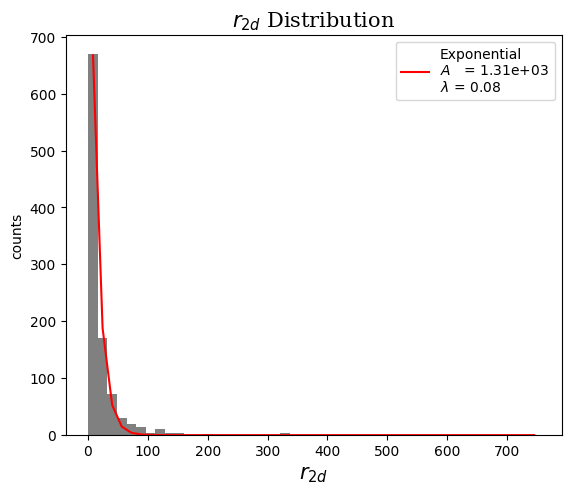

In [15]:
grasp.plots.histogram(r_ratio, kde=True, kde_kind='exponential', xlabel=r'$r_{2d}$')

In [16]:
reg_e = grasp.stats.regression(r_ratio[r_ratio<400], 'exponential', False)
reg_p = grasp.stats.regression(r_ratio[r_ratio<400], 'power', False)

Correctly imported `minpack.lm`.
Correctly imported `minpack.lm`.


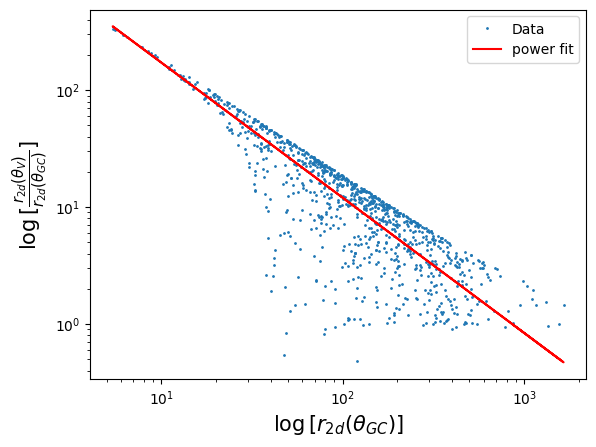

In [17]:
fit_p = grasp.stats.fit_data(r_ratio[r_ratio<400], fit='power', x_data = r2d_1[r_ratio<400])
#fit_e = grasp.stats.fit_data(r_ratio[r_ratio<400], fit='exponential', x_data = r2d_1[r_ratio<400])

plt.plot(r2d_1[r_ratio<400], r_ratio[r_ratio<400], 'o', markersize=1, label='Data')
plt.plot(r2d_1[r_ratio<400], fit_p.y, c='r', label='power fit')
#plt.plot(r2d_1[r_ratio<400], fit_e.y, c='g', label='exponential fit')
plt.xlabel(r'$\log{[r_{2d}(\theta_{GC})]}$', fontdict=grasp.plots.label_font)
plt.ylabel(r'$\log{[\frac{r_{2d}(\theta_{V})}{r_{2d}(\theta_{GC})}]}$', fontdict=grasp.plots.label_font)
plt.yscale('log')
plt.xscale('log')
plt.legend()

# Radial Distance $R$

### Computing $d$ and $r_x$

In [18]:
f.los_distance

Eq(r_{x}, 1/omega)

In [19]:
f.gc_z_coordinate


Eq(d, -r_{c} + r_{x})

In [20]:
f.radial_distance_3d

Eq(R, sqrt(d**2 + r_{2}**2))

In [21]:
f.var_order('los_distance')
f.var_order('gc_z_coordinate')
f.substitute('gc_z_coordinate', {'r_{c}': aps.gc.dist})
print('')
r_x = f.compute('los_distance', data={'omega': aps.parallax}, asarray=True) * 1000
print('')
d = f.compute('gc_z_coordinate',data={'r_{x}': r_x}, asarray=True)


`Los distance' variables must be passed in the following order:
Data         : [omega]
Errors       : [epsilon_omega]
Correlations : None

`Gc z coordinate' variables must be passed in the following order:
Data         : [r_{c}, r_{x}]
Errors       : [epsilon_r_{c}, epsilon_r_{x}]
Correlations : [rho_r_{c}_r_{x}]

WARNING! Be sure that the input data follow this specific order: 
Data:         [omega]
Computation using all 16 cores.

WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{x}]
Computation using all 16 cores.


### $R(\theta_V)$

In [22]:
f.var_order('radial_distance_3d')


`Radial distance 3d' variables must be passed in the following order:
Data         : [d, r_{2}]
Errors       : [epsilon_d, epsilon_r_{2}]
Correlations : [rho_d_r_{2}]


WARNING! Be sure that the input data follow this specific order: 
Data:         [d, r_{2}]
Computation using all 16 cores.


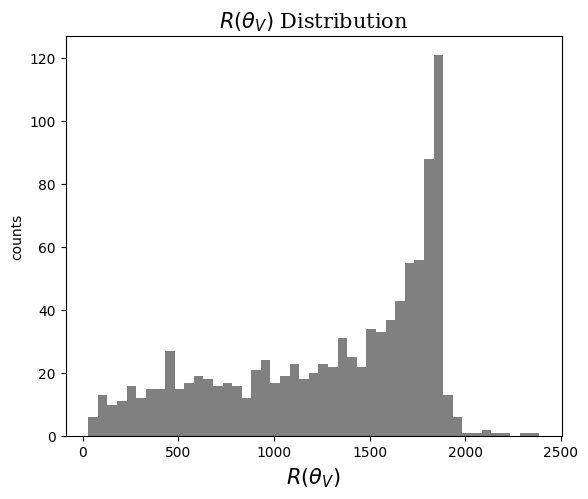

In [23]:
R_V = f.compute('radial_distance_3d', data={'d': d,'r_{2}': r2d_2,}, asarray=True)
grasp.plots.histogram(R_V, xlabel=r'$R(\theta_V)$')

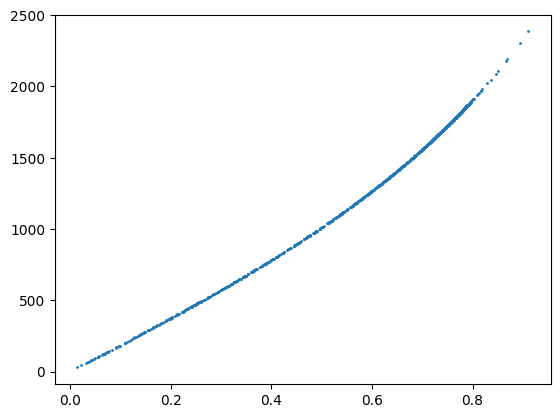

In [24]:
plt.scatter(theta_2, R_V, s=1)

### $R(\theta_{GC}$)

WARNING! Be sure that the input data follow this specific order: 
Data:         [d, r_{2}]
Computation using all 16 cores.
Correctly imported `minpack.lm`.


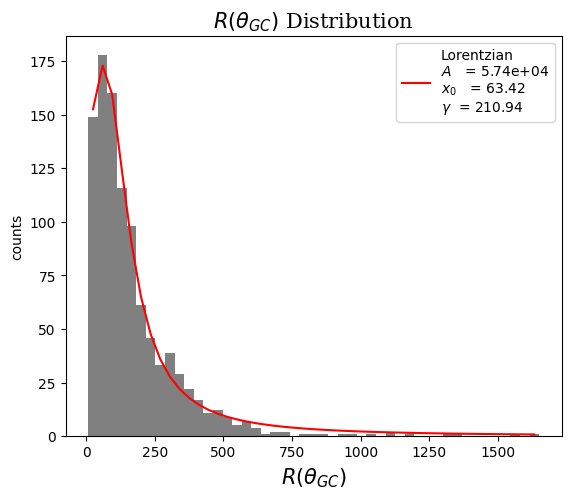

In [25]:
R_GC = f.compute('radial_distance_3d', {'d': d,'r_{2}': r2d_1,}, asarray=True)
rgc_hist = grasp.plots.histogram(R_GC, xlabel=r'$R(\theta_{GC})$', kde=True, kde_kind='lorentzian', out=True, kde_verbose=False)

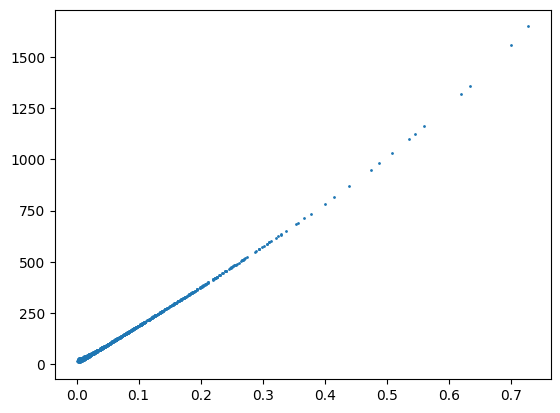

In [26]:
plt.scatter(theta_1, R_GC, s=1)

## $R(\theta_V)$ vs $R(\theta_{GC})$

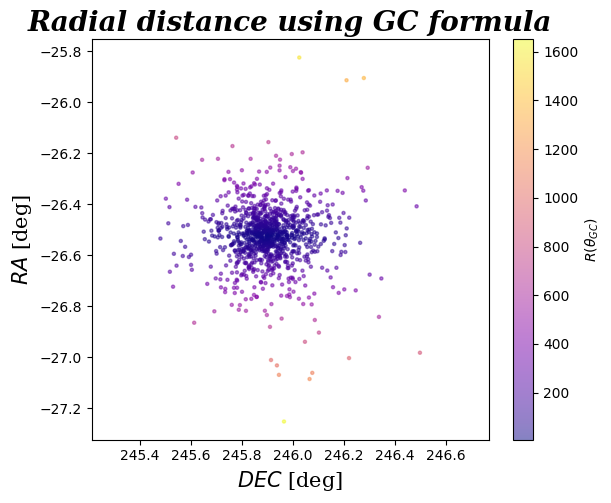

In [27]:
grasp.plots.spatial(aps, color=R_GC, colorbar=True, colorbar_label=r'$R(\theta_{GC})$', cmap='plasma', title='Radial distance using GC formula')

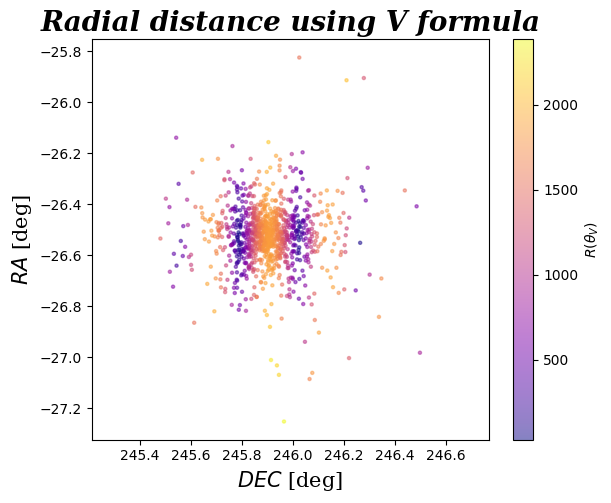

In [28]:
grasp.plots.spatial(aps, color=R_V, colorbar=True, colorbar_label=r'$R(\theta_{V})$', cmap='plasma', title='Radial distance using V formula')

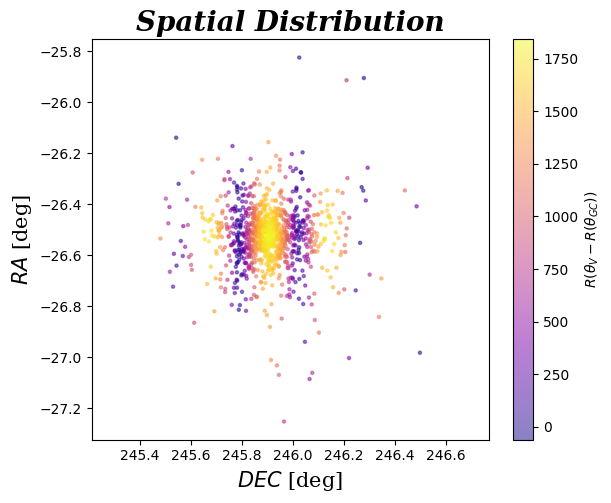

In [29]:
grasp.plots.spatial(aps, color=R_V-R_GC, colorbar=True, colorbar_label=r'$R(\theta_{V}-R(\theta_{GC}))$', cmap='plasma')

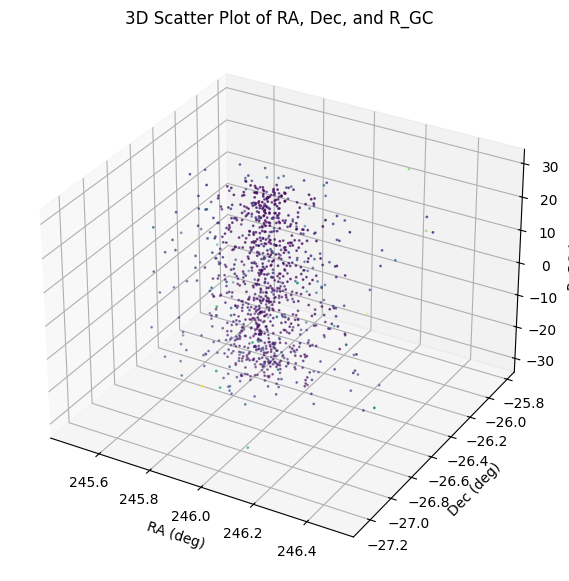

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(aps.ra, aps.dec, d, c=R_GC, cmap='viridis', s=1)

ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_zlabel('d (pc)')
ax.set_title('3D Scatter Plot of RA, Dec, and R_GC')

plt.show()